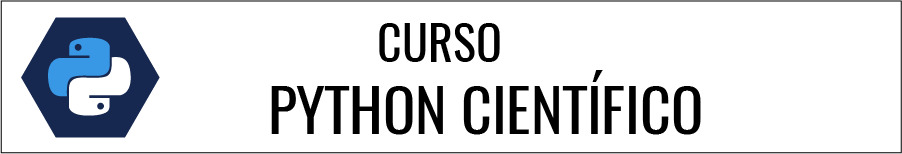

# Cubic Splines

### Modules - Curve Fitting
<section class="post-meta">
By Jonas Tjemsland, Eilif S. Øyre and Jon Andreas Støvneng
</section>
Last edited: January 26th 2018 
___

*Splines* es un tipo de interpolación de datos, un método para (re) construir una función entre un conjunto dado de puntos de datos. La interpolación se puede utilizar para representar funciones complicadas y computacionalmente exigentes como p. Ej. polinomios Luego, usando una tabla de algunas evaluaciones de funciones, uno puede aproximar fácilmente la verdadera función con alta precisión.

En la interpolación spline, los datos son interpolados por varios polinomios de bajo grado. Esto difiere de la interpolación polinómica, en la que los datos se interpolan por un solo polinomio de alto orden. Para una discusión general sobre la interpolación polinómica, le remitimos a nuestro cuaderno sobre interpolación polinómica [polynomial interpolation](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/polynomial_interpolation.ipynb). 

El ejemplo más simple de interpolación de spline es splines lineales, donde los puntos de datos están simplemente conectados por líneas rectas. Vamos a discutir la interpolación por splines cúbicas, que interpola los polinomios usando polinomios cúbicos con derivadas continuas primera y segunda. Crearemos un algoritmo y algunas funciones para calcular una spline cúbica.

Comenzamos importando paquetes necesarios y estableciendo parámetros de figuras comunes.

In [ ]:
https://www.scipy.org/install.html

In [ ]:
# pip install scipy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg as la

%matplotlib inline

# Establecer algunos parámetros de figura
newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

## Un simple ejemplo
Supongamos que nos dan cuatro puntos como datos: $\{(0, 0), (1, -1), (2, 2), (3, 0)\}$. 

La función spline cúbica que interpola estos puntos es
$$
S(x) =
\begin{cases}
-\frac{12}{5}x + \frac{7}{5}x^3, & 0\leq x < 1,\\
-1 + \frac{9}{5}(x - 1) + \frac{21}{5}(x-1)^2 - 3(x-1)^3, & 1 \leq x < 2,\\
2 + \frac{6}{5}(x - 2) -\frac{24}{5}(x-2)^2 + \frac{8}{5}(x-2)^3, & 2 \leq x < 3.\\
\end{cases}
$$

¡Tracemos los puntos de datos, la spline lineal y la spline cúbica!

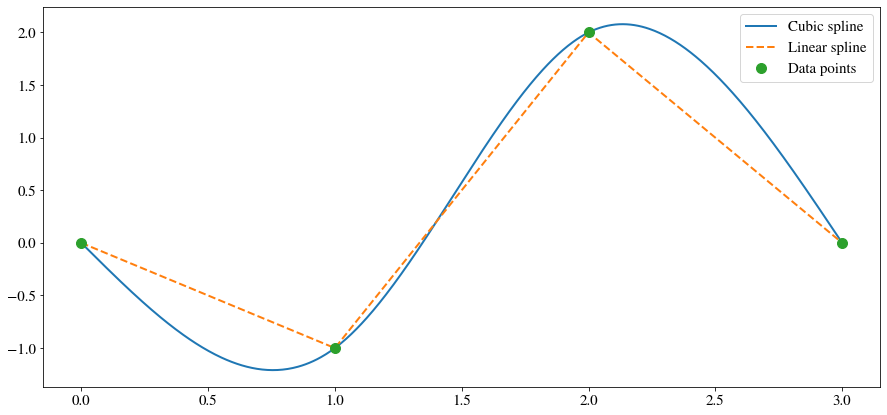

In [5]:
n = 200
x1 = np.linspace(0, 1, n)
x2 = np.linspace(1, 2, n)
x3 = np.linspace(2, 3, n)

# Cubic spline
S1 = -12/5*x1 + 7/5*x1**3
S2 = -1 + 9/5*(x2 - 1) + 21/5*(x2 - 1)**2 - 3*(x2 - 1)**3
S3 = 2 + 6/5*(x3 - 2) - 24/5*(x3 - 2)**2 + 8/5*(x3 - 2)**3
plt.plot(np.concatenate([x1, x2, x3]),  np.concatenate([S1, S2, S3]), label="Cubic spline")
# Linear spline
plt.plot([0, 1, 2, 3], [0, -1, 2, 0], "--", label="Linear spline")
# Data points
plt.plot([0, 1, 2, 3], [0, -1, 2, 0], "o", label="Data points")

plt.legend()
plt.show()

**Ejercicio:** Verifique que la spline cúbica anterior tenga derivadas continuas primera y segunda.

## Definicion

Un spline cúbico general $S(x)$ interpolando los $n$ puntos de datos $\{(x_1,y_1), (x_2, y_2),..., (x_n, y_n)\}$ se puede escribir como

\begin{equation}
S(x) =
\begin{cases}
S_1(x) &= y_1 + b_1(x - x_1) + c_1(x-x_1)^2 + d_1(x-x_1)^3, & \text{for } x\in[x_1, x_2],\\
S_2(x) &= y_2 + b_2(x - x_2) + c_2(x-x_2)^2 + d_2(x-x_2)^3, & \text{for } x\in[x_2, x_3],\\
&\vdots&\\
S_{n-1}
(x) &= y_{n-1} + b_{n-1}(x - x_{n-1}) + c_{n-1}(x-x_{n-1})^2 + d_{n-1}(x-x_{n-1})^3, & \text{for } x\in[x_{n-1}, x_n],\\
\end{cases}
\label{eq:spline}
\end{equation}

para algunas constantes $b_i, c_i, d_i$, $i=1, ..., n$. 

Como se mencionó en la introducción, exigimos que los spline sean continuos y tengan derivadas continuas primera y segunda.

Esto le da las siguientes propiedades: [1]

1\. $S_i(x_i)=y_i$ and $S_i(x_{i+1})=y_{i+1}$ for $i=1,...,n-1$,  
2\. $S_{i-1}'(x_i)=S_{i}'(x_i)$ and $S_i(x_{i+1})=y_{i+1}$ for $i=2,...,n-1$,  
3\. $S_{i-1}''(x_i)=S_{i}''(x_i)$ and $S_i(x_{i+1})=y_{i+1}$ for $i=2,...,n-1$.  

Las tres propiedades aseguran que la spline sea continua y suave.

El número total de constantes. $b_i, c_i, d_i$ que necesitamos calcular es $3(n-1)$.

## Condiciones de punto final

Tenga en cuenta que el número total de condiciones impuestas por las propiedades anteriores es $3n-5$.  
Sin embargo, el número total de coeficientes $b_i, c_i, d_i$ Nosotros necesitamos calcular es $3(n-1)$.  
Por lo tanto, necesitamos dos condiciones adicionales para hacer los spline $S(x)$ únicos. Esto se logra a través de condiciones de punto final.

Hay varias opciones de condiciones de punto final (see e.g. [1]). Consideraremos * splines cúbicos naturales *,

4a\. $S''_1(x_1)= 0$ and $S''_{n-1}(x_n)=0$,

y *splines cúbicos sin nudos*

4b\. $S_1'''(x_2)=S_2'''(x_2), \; S_{n-2}'''(x_{n-1})=S_{n-1}'''(x_{n-1})$.

**Exercicio:** ¿Qué condición de punto final se usa en el ejemplo anterior?

## Algoritmo

From property 1, 2 and 3 we obtain

\begin{equation}
y_{i+1} = y_{i}+b_{i}(x_{i+1}-x_i) + c_i(x_{i+1}-x_i)^2 + d_i(x_{i+1}-x_i)^3, \quad i=1,...,n-1,
\label{eq:prop1}
\end{equation}

\begin{equation}
0 = b_i + 2c_i(x_{i+1}-x_i) + 3d_i(x_{i+1}-x_i)^2-b_{i+1}, \quad i=1,...,n-2,
\label{eq:prop2}
\end{equation}

and

\begin{equation}
0 = c_i+3d_i(x_{i+1}-x_i)-c_{i+1}, \quad i=1,...,n-2,
\label{eq:prop3}
\end{equation}

respectively. The derivation is straight forward, and is left as an exercise for the reader. If we solve these equations, we obtain the constants $b_i, c_i, d_i$ and thus the cubic spline. To simplify the notation, we define $\Delta x_i=x_{i+1}-x_i$ and $\Delta y_i = y_{i+1}-y_i$. By using equation \eqref{eq:prop1} and \eqref{eq:prop3} we obtain the following expressions for $b_i$ and $d_i$ in terms of the $c$-coefficients:

\begin{align}
d_i &= \frac{c_{i+1}-c_i}{3\Delta x_i}, \label{eq:d}\\
b_i &= \frac{\Delta y_i}{\Delta x_i}-\frac{1}{3}\Delta x_i (2 c_i + c_{i+1}).\label{eq:b}
\end{align}

If we insert this into equation \eqref{eq:prop2} we obtain,

$$\Delta x_ic_i + 2(\Delta x_i + \Delta x_{i+1})c_{i+1}+\Delta x_{i+2}c_{i+2} = 3\left(\frac{\Delta y_{i+1}}{\Delta x_{i+1}}-\frac{\Delta y_{i}}{\Delta x_{i}}\right)$$

which is $n-2$ equations for $c_1,..., c_n$. The *natural spline* endpoint condition gives $c_1=c_n=0$. We can write this as the matrix equation

$$
\begin{pmatrix}
1 & 0 & 0 & 0 & \cdots & 0 & 0 \\
\Delta x_1 & 2\Delta x_1 + 2\Delta x_2 & \Delta x_2 & 0 & \cdots&0&0\\
0 & \Delta x_2 & 2\Delta x_2 + 2\Delta x_3 & \Delta x_3 & \cdots&0&0\\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \Delta x_{n-2} & 2\Delta x_{n-2} + 2\Delta x_{n-1} & \Delta x_{n-1}\\
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
c_1 \\ c_2 \\ \\ \vdots \\ \\ c_n
\end{pmatrix} = 
\begin{pmatrix}
0 \\
3\left(\frac{\Delta y_{2}}{\Delta x_2}-\frac{\Delta y_1}{\Delta x_1}\right) \\
\vdots
\\
3\left(\frac{\Delta y_{n-1}}{\Delta x_{n-1}}-\frac{\Delta y_{n-2}}{\Delta x_{n-2}}\right) \\
0
\end{pmatrix}.
$$

The algorithm for finding the spline is now quite apparent. We start by constructing the matrix equation, then solve it to find $c_i$ and in turn compute $b_i$ and $d_i$ via the equations \eqref{eq:d} and \eqref{eq:b}.

The first and last row of the matrix is altered with the *not-a-knot* endpoint conditions. Note that property 4b implies $d_1=d_2$ and $d_{n-2}=d_{n-1}$. If we insert this into equation \eqref{eq:d} for $d_i$, we obtain
$$\Delta x_2 c_1 -(\Delta x_1 + \Delta x_2) c_2 + \Delta x_1 c_3 = 0,$$
$$\Delta x_{n-1} c_{n-1} -(\Delta x_{n-2} + \Delta x_{n-1})c_{n-1}+\Delta x_{n-2}c_n = 0.$$
The first row in with the *not-a-knot* end conditions becomes $$(\Delta x_2\;\; -(\Delta x_1 + \Delta x_2)\;\; \Delta x_1\;\; 0\;\; 0\;\; ...).$$ Likewise, the last row becomes $$(0\;\; ... \;\; 0 \;\; \Delta x_{n-1}\;\; -(\Delta x_{n-2} + \Delta x_{n-2})\;\; \Delta x_{n-2}).$$

We now proceed to create a function that computes the cubic spline that interpolates the points $\{(x_1,y_1), (x_2, y_2),..., (x_n, y_n)\}$. Note that the matrix equation above is tridiagonal, and it can therefore be stored as a $3\times n$ array and solved effectively by using [scipy.linalg.solve_banded](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html). In the *not-a-knot*-case the matrix becomes a banded matrix with two upper and lower diagonals.

**Exercise:** Derive equations \eqref{eq:prop1}, \eqref{eq:prop2} and \eqref{eq:prop3} from the properties 1-3.

In [6]:
def cubic_spline_coeffs(x, y, endpoint="natural"):
    """ Computes the coefficients in the cubic spline that interpolates
    the points (x_1,y_1), (x_2, y_2),..., (x_n, y_n).
    Parameters:
        x: array_like, shape (n>2,).
           x-value of the points being interpolated. Values must be
           real and in strictly increasing order.
        y: array_like, shape (n>2,)
           y-value of the points being interpolated. Values must be
           real.
    Returns:
        array, shape (3, n). The coefficients b, c and d, stored in
        the first, second and third row, respectively.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    dx = np.diff(x)
    dy = np.diff(y)

    # Find the vector for the right hand side
    rhs = np.zeros(n)
    rhs[1:-1] = 3*(dy[1:]/dx[1:] - dy[:-1]/dx[:-1])

    # Compute the matrix and store a matrix diagonal ordered form
    if (endpoint == "natural"):
        matrix = np.zeros((3, n))
        bands = (1, 1)
        matrix[1, 1:-1] = 2*(dx[:-1] + dx[1:]) # Diagonal
        matrix[1, 0] = matrix[1, -1] = 1
        matrix[0, 2:] = dx[1:] # Upper diagonal
        matrix[2, :-2] = dx[:-1] # Lower diagonal
    
    if (endpoint == "not-a-knot"):
        matrix = np.zeros((5, n))
        bands = (2, 2)
        matrix[2, 1:-1] = 2*(dx[:-1] + dx[1:]) # Diagonal
        matrix[1, 2:] = dx[1:] # Upper diagonal
        matrix[3, :-2] = dx[:-1] # Lower diagonal
        # First row
        matrix[2, 0] = dx[1]
        matrix[1, 1] = -dx[0] - dx[1]
        matrix[0, 2] = dx[0]
        # Last row
        matrix[2, -1] = dx[-2]
        matrix[3, -2] = -dx[-2] - dx[-3]
        matrix[4, -3] = dx[-1]
        
    # Call a solver for a banded matrix
    c = la.solve_banded(bands, matrix, rhs,
            overwrite_ab=True, overwrite_b=True, check_finite=False)
    
    # Find the remainding coefficients
    d = np.diff(c)/(3*dx)
    b = dy/dx - dx*(2*c[:-1] + c[1:])/3
    
    return b, c, d

We also need a function that can evaluate the spline given the coefficients.

In [7]:
def cubic_spline_eval(x, xdata, ydata, b, c, d):
    """ Evaluates the cubic spline that interpolates {(xdata, ydata)}
    at x with coefficients b, c and d.
    Parameters:
        x:          array_like, shape(m,).
                    x-values (axis) at which the spline is evaluated.
        a, b, c, d: array_like, shapes (n,), (n-1,), (n,) and (n-1,).
                    Coefficients of the spline.
    Return:
        array, shape(m,). Function evaluation of the spline.
    """
    x = np.asarray(x)
    y = np.zeros(len(x))
    m = 0
    for i in range(len(xdata) - 1):
        n = np.sum(x < xdata[i + 1]) - m
        xx = x[m:m + n] - xdata[i]
        y[m:m + n] = ydata[i] + b[i]*xx + c[i]*xx**2 + d[i]*xx**3
        m = m + n
    xx = x[m:] - xdata[-2]
    y[m:] = ydata[-2] + b[-1]*xx + c[-2]*xx**2 + d[-1]*xx**3
    return y

## Ejemplo
Ahora estamos listos para encontrar la spline cúbica de un conjunto general de puntos de datos. Para obtener alguna base de comparación, interpolaremos algunos puntos de $\sin(x)$.

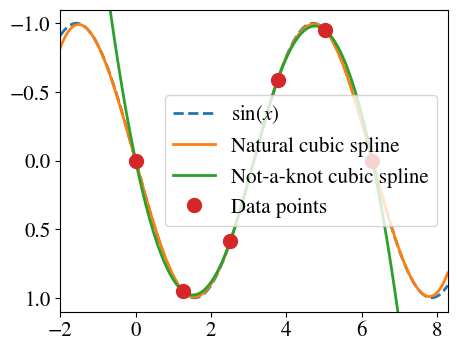

In [8]:
def func(x):
    return np.sin(x)

xdata = np.asarray([0, 2, 4, 6, 8, 10])*np.pi/5
ydata = func(xdata)

x = np.linspace(xdata[0] - 2, xdata[-1] + 2, 200)
y = func(x)

b, c, d = cubic_spline_coeffs(xdata, ydata, "natural")
ya = cubic_spline_eval(x, xdata, ydata, b, c, d)

b, c, d = cubic_spline_coeffs(xdata, ydata, "not-a-knot")
yb = cubic_spline_eval(x, xdata, ydata, b, c, d)

#plt.figure()
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(x, y, "--", label=r"$\sin(x)$")
plt.plot(x, ya, label="Natural cubic spline")
plt.plot(x, yb, label="Not-a-knot cubic spline")
plt.plot(xdata, ydata, 'o', label="Data points")
plt.xlim(x[0], x[-1])
plt.ylim(np.max(y)*1.1, np.min(y)*1.1)
plt.legend()
#plt.figure(figsize=(5, 4), dpi=80)
plt.show()

Tenga en cuenta que hemos definido las splines cúbicas fuera del dominio de los puntos de datos. En la estría cúbica no un nudo se extienden los polinomios exteriores. Es decir, el polinomio en $x<x_1$ Es lo mismo que para $x_1<x<x_2$.  
La spline cúbica natural, por otro lado, define un polinomio con "curvatura opuesta" fuera de los puntos de datos. Es decir, si la spline se curva lejos del eje en $x_1<x<x_2$ se curvará hacia el eje en $x<x_1$.

## Interpolar curvas parametrizadas
También es posible interpolar curvas parametrizadas con splines. Esto se realiza haciendo la interpolación tanto en el eje x como en el eje y como funciones del parámetro de curva.  
Considere el siguiente ejemplo:

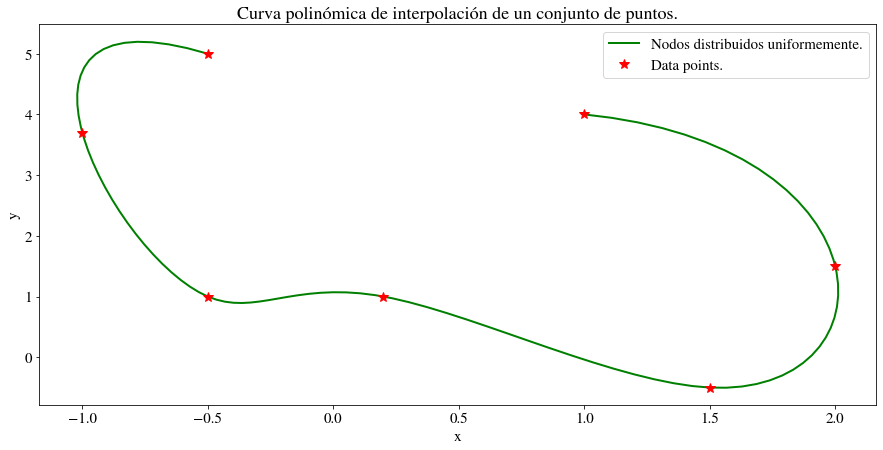

In [9]:
# Definir algunos puntos de datos.
xdata = [-0.5,-1.0,-0.5, 0.2, 1.5, 2.0, 1.0]
ydata = [ 5.0, 3.7, 1.0, 1.0,-0.5, 1.5, 4.0]
n = len(xdata)

# Valores paramétricos
t = np.linspace(0,1,100)

# Interpolación de curvas utilizando nodos de parámetros distribuidos uniformemente
ti = np.linspace(0,1,n)
# x-axis
b, c, d = cubic_spline_coeffs(ti, xdata, "not-a-knot")
Px = cubic_spline_eval(t, ti, xdata, b, c, d)
# y-axis
b, c, d = cubic_spline_coeffs(ti, ydata, "not-a-knot")
Py = cubic_spline_eval(t, ti, ydata, b, c, d)

plt.figure
plt.plot(Px,Py,'g',label='Nodos distribuidos uniformemente.')
plt.plot(xdata,ydata,'r*',label='Data points.')
plt.title('Curva polinómica de interpolación de un conjunto de puntos.')
plt.legend(), plt.xlabel('x'), plt.ylabel('y')
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;**Exercise:** Use the Chebychev nodes instead of the uniformly distributed parameter nodes. *Hint. See the [polynomial interpolation](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/polynomial_interpolation.ipynb) notebook.*

## Why Cubic Splines?
There are several benefits of using cubic splines opposed to e.g. a high order polynomial interpolation or higher order splines. In our notebook on [polynomial interpolation](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/polynomial_interpolation.ipynb) we showed that large oscillations (and thus large errors) may occur when approximating a function using a high order polynomial. This is called *Runge's phenomenon*. We showed that the error due to this oscillation is minimized when using so-called *Chebyshev nodes* as base for the interpolation. Another workaround is to use low order polynomial splines.

You may be wondering why we don't use a quadratic spline instead of cubic splines. Approximating a function using more function evaluations and higher order polynomials must always be better, right? Wrong! We may of course argue that higher order polynomial splines gives smoother curves, since we are demanding that higher order derivatives are continuous. This may, however, lead to larger errors due to Runge's phenomenon. In addition, higher order polynomial interpolations require more data points. The global change in the curve due to the change in a single data point is thus increased in higher order polynomial splines.

## References and Further Reading

[1] Sauer, T.: Numerical Analysis international edition, second edition, Pearson 2014  
[2] Press, W.H., Teukolsky, S.A., Vetterling, W.T., Flannery, B.P.: Numerical Recipes, the Art of Scientific Computing, 3rd edition, Cambridge University Press 2007  

[scipy.interpolate](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) has several function for polynomial and spline interpolation, such as [CubicSpline](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline) and [interp1d](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d). Check them out!